You may find this series of notebooks at https://github.com/databricks-industry-solutions/oncology. For more information about this solution accelerator, visit https://www.databricks.com/solutions/accelerators/nlp-oncology.

#Abstracting Real World Data from Oncology Notes: Entity Extraction
[MT ONCOLOGY NOTES](https://www.mtsamplereports.com/) comprises of millions of ehr records of patients. It contains semi-structured data like demographics, insurance details, and a lot more, but most importantly, it also contains free-text data like real encounters and notes.
Here we show how to use Spark NLP's existing models to process raw text and extract highly specialized cancer information that can be used for various downstream use cases, including:
- Staff demand analysis according to specialties.
- Preparing reimbursement-ready data with billable codes.
- Analysis of risk factors of patients and symptoms.
- Analysis of cancer disease and symptoms.
- Drug usage analysis for inventory management.
- Preparing timeline of procedures.
- Relations between internal body part and procedures.
- Analysis of procedures used on oncological events.
- Checking assertion status of oncological findings.

##0. Initial configurations

In [0]:
%pip install mlflow

Python interpreter will be restarted.
Collecting mlflow
 Downloading mlflow-2.1.1-py3-none-any.whl (16.7 MB)
Collecting cloudpickle<3
 Downloading cloudpickle-2.2.0-py3-none-any.whl (25 kB)
Requirement already satisfied: databricks-cli<1,>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.17.4)
Requirement already satisfied: click<9,>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.1.3)
Requirement already satisfied: pytz<2023 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Collecting sqlparse<1,>=0.4.0
 Downloading sqlparse-0.4.3-py3-none-any.whl (42 kB)
Requirement already satisfied: entrypoints<1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: requests<3,>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.25.1)
Requirement already satisfied: numpy<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.22.0)
Requirement already satisfied: pyarrow<11,>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (4.0.0)
Requirement already satisfied: pandas<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.5.2)
Collecting docker<7,>=4.0.0
 Downloading docker-6.0.1-py3-none-any.whl (147 kB)
Requirement already satisfied: markdown<4,>=3.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.4.1)
Requirement already satisfied: scikit-learn<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.24.1)
Requirement already satisfied: Jinja2<4,>=2.11 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.11.3)
Requirement already satisfied: importlib-metadata!=4.7.0,<6,>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.2.0)
Requirement already satisfied: protobuf<5,>=3.12.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.2)
Collecting pyyaml<7,>=5.1
 Downloading PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
Collecting shap<1,>=0.40
 Downloading shap-0.41.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (575 kB)
Collecting alembic<2
 Downloading alembic-1.9.1-py3-none-any.whl (210 kB)
Collecting gitpython<4,>=2.1.0
 Downloading GitPython-3.1.30-py3-none-any.whl (184 kB)
Requirement already satisfied: matplotlib<4 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.4.2)
Requirement already satisfied: scipy<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.2)
Collecting sqlalchemy<2,>=1.4.0
 Downloading SQLAlchemy-1.4.45-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
Collecting gunicorn<21
 Downloading gunicorn-20.1.0-py3-none-any.whl (79 kB)
Collecting Flask<3
 Downloading Flask-2.2.2-py3-none-any.whl (101 kB)
Collecting querystring-parser<2
 Downloading querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
Requirement already satisfied: packaging<23 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.9)
Collecting importlib-resources
 Downloading importlib_resources-5.10.2-py3-none-any.whl (34 kB)
Collecting Mako
 Downloading Mako-1.2.4-py3-none-any.whl (78 kB)
Requirement already satisfied: oauthlib>=3.1.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (3.2.2)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (1.15.0)
Requirement already satisfied: pyjwt>=1.7.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (2.6.0)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (0.9.0)
Collecting websocket-client>=0.32.0
 Downloading websocket_client-1.4.2-py3-none-any.whl (55 kB)
Collecting urllib3>=1.26.0
 Downloadin

In [0]:
import os
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL

from johnsnowlabs import nlp, medical, viz

warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

spark

Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

### Download oncology notes

In [0]:
%run
./04-onco_config

In [0]:
data_path = '/FileStore/HLS/nlp/data/'

ade_demo_util=SolAccUtil('onc-lh',data_path=data_path)
ade_demo_util.print_info()

base_path = /home/ahmet@johnsnowlabs.com/health-lakehouse delta_path = /home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta data_path = /FileStore/HLS/nlp/data/ experiment_name = /Users/ahmet@johnsnowlabs.com/onc-lh experiment_id = 3845599403064227 artifact_location = dbfs:/databricks/mlflow-tracking/3845599403064227 tags = {'mlflow.ownerId': '3583539445967905', 'mlflow.experiment.sourceName': '/Users/ahmet@johnsnowlabs.com/onc-lh', 'mlflow.ownerEmail': 'ahmet@johnsnowlabs.com', 'mlflow.experimentType': 'MLFLOW_EXPERIMENT'}

In [0]:
mlflow.set_experiment(ade_demo_util.settings['experiment_name'])

Out[5]: <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3845599403064227', creation_time=1662655119902, experiment_id='3845599403064227', last_update_time=1662655119902, lifecycle_stage='active', name='/Users/ahmet@johnsnowlabs.com/onc-lh', tags={'mlflow.experiment.sourceName': '/Users/ahmet@johnsnowlabs.com/onc-lh',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'ahmet@johnsnowlabs.com',
 'mlflow.ownerId': '3583539445967905'}>

In [0]:
data_path=ade_demo_util.settings['data_path']
os.environ['data_path']=f'/dbfs{data_path}'
delta_path=ade_demo_util.settings['delta_path']
notes_path = f'{data_path}/mt_onc_50/'

In [0]:
%sh
cd $data_path
wget https://hls-eng-data-public.s3.amazonaws.com/data/mt_onc_50.zip
unzip -o mt_onc_50.zip

--2022-12-29 10:25:28-- https://hls-eng-data-public.s3.amazonaws.com/data/mt_onc_50.zip
Resolving hls-eng-data-public.s3.amazonaws.com (hls-eng-data-public.s3.amazonaws.com)... 52.217.87.220, 52.217.229.153, 52.216.216.121, ...
Connecting to hls-eng-data-public.s3.amazonaws.com (hls-eng-data-public.s3.amazonaws.com)|52.217.87.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93586 (91K) [application/zip]
Saving to: ‘mt_onc_50.zip.32’

 0K .......... .......... .......... .......... .......... 54% 8.90M 0s
 50K .......... .......... .......... .......... . 100% 17.3M=0.008s

2022-12-29 10:25:28 (11.4 MB/s) - ‘mt_onc_50.zip.32’ saved [93586/93586]

Archive: mt_onc_50.zip
 inflating: mt_onc_50/mt_oncology_0.txt 
 inflating: mt_onc_50/mt_oncology_1.txt 
 inflating: mt_onc_50/mt_oncology_10.txt 
 inflating: mt_onc_50/mt_oncology_11.txt 
 inflating: mt_onc_50/mt_oncology_12.txt 
 inflating: mt_onc_50/mt_oncology_13.txt 
 inflating: mt_onc_50/mt_oncology_14.txt 
 inflating: mt_onc_50/mt_oncology_15.txt 
 inflating: mt_onc_50/mt_oncology_16.txt 
 inflating: mt_onc_50/mt_oncology_17.txt 
 inflating: mt_onc_50/mt_oncology_18.txt 
 inflating: mt_onc_50/mt_oncology_19.txt 
 inflating: mt_onc_50/mt_oncology_2.txt 
 inflating: mt_onc_50/mt_oncology_20.txt 
 inflating: mt_onc_50/mt_oncology_21.txt 
 inflating: mt_onc_50/mt_oncology_22.txt 
 inflating: mt_onc_50/mt_oncology_23.txt 
 inflating: mt_onc_50/mt_oncology_24.txt 
 inflating: mt_onc_50/mt_oncology_25.txt 
 inflating: mt_onc_50/mt_oncology_26.txt 
 inflating: mt_onc_50/mt_oncology_27.txt 
 inflating: mt_onc_50/mt_oncology_28.txt 
 inflating: mt_onc_50/mt_oncology_29.txt 
 inflating: mt_onc_50/mt_oncology_3.txt 
 inflating: mt_onc_50/mt_oncology_30.txt 
 inflating: mt_onc_50/mt_oncology_31.txt 
 inflating: mt_onc_50/mt_oncology_32.txt 
 inflating: mt_onc_50/mt_oncology_33.txt 
 inflating: mt_onc_50/mt_oncology_34.txt 
 inflating: mt_onc_50/mt_oncology_35.txt 
 inflating: mt_onc_50/mt_oncology_36.txt 
 inflating: mt_onc_50/mt_oncology_37.txt 
 inflating: mt_onc_50/mt_oncology_38.txt 
 inflating: mt_onc_50/mt_oncology_39.txt 
 inflating: mt_onc_50/mt_oncology_4.txt 
 inflating: mt_onc_50/mt_oncology_40.txt 
 inflating: mt_onc_50/mt_oncology_41.txt 
 inflating: mt_onc_50/mt_oncology_42.txt 
 inflating: mt_onc_50/mt_oncology_43.txt 
 inflating: mt_onc_50/mt_oncology_44.txt 
 inflating: mt_onc_50/mt_oncology_45.txt 
 inflating: mt_onc_50/mt_oncology_46.txt 
 inflating: mt_onc_50/mt_oncology_47.txt 
 inflating: mt_onc_50/mt_oncology_48.txt 
 inflating: mt_onc_50/mt_oncology_49.txt 
 inflating: mt_onc_50/mt_oncology_5.txt 
 inflating: mt_onc_50/mt_oncology_6.txt 
 inflating: mt_onc_50/mt_oncology_7.txt 
 inflating: mt_onc_50/mt_oncology_8.txt 
 inflating: mt_onc_50/mt_oncology_9.txt

In [0]:
display(dbutils.fs.ls(notes_path), 10)

path,name,size
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,mt_oncology_0.txt,5471
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_1.txt,mt_oncology_1.txt,3241
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_10.txt,mt_oncology_10.txt,4291
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_11.txt,mt_oncology_11.txt,2058
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_12.txt,mt_oncology_12.txt,3405
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_13.txt,mt_oncology_13.txt,1561
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_14.txt,mt_oncology_14.txt,2555
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_15.txt,mt_oncology_15.txt,9395
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_16.txt,mt_oncology_16.txt,2096
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_17.txt,mt_oncology_17.txt,1992


### Read Data and Write to Bronze Delta Layer

There are 50 clinical notes stored in delta table. We read the data nd write the raw notes data into bronze delta tables

In [0]:
df = sc.wholeTextFiles(notes_path).toDF().withColumnRenamed('_1','path').withColumnRenamed('_2','text')
display(df.limit(5))

path text dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion.
PAST MEDICAL HISTORY
1. Pericardectomy.
2. Pericarditis.
2. Atrial fibrillation.
4. RNCA with intracranial thrombolytic treatment.
5 PTA of MCA.
6. Mesenteric venous thrombosis.
7. Pericardial window.
8. Cholecystectomy.
9. Left thoracentesis.
FAMILY HISTORY:
No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.
SOCIAL HISTORY:
She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use.
MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.
REVIEW OF SYSTEMS:
Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.
PHYSICAL EXAMINATION
VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.
GENERAL: Positive nonproductive cough and pain with coughing.
HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.
NECK: Supple. No lymphadenopathy. No masses.
RESPIRATORY: Pleural friction rub is noted.
GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.
EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.
SKIN: No breakdown or lesions. No ulcers.
NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.
LABORATORY DATA:
Labs are pending.
HOSPITAL COURSE:
The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with f

In [0]:
df.count()

Out[10]: 50

In [0]:
df.write.format('delta').mode('overwrite').save(f'{delta_path}/bronze/mt-oc-notes')
display(dbutils.fs.ls(f'{delta_path}/bronze/mt-oc-notes'))

path,name,size
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/_delta_log/,_delta_log/,0
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-3ad61670-2fb5-4010-8b96-a4fc39484951-c000.snappy.parquet,part-00000-3ad61670-2fb5-4010-8b96-a4fc39484951-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-4f1f8064-8772-48fb-8b88-2591bf3204e7-c000.snappy.parquet,part-00000-4f1f8064-8772-48fb-8b88-2591bf3204e7-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-5dd510a4-b70f-45bb-8b23-e7bc2d993563-c000.snappy.parquet,part-00000-5dd510a4-b70f-45bb-8b23-e7bc2d993563-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-aaeaee39-c8b8-4f57-8672-e48106ee2122-c000.snappy.parquet,part-00000-aaeaee39-c8b8-4f57-8672-e48106ee2122-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-14d180fd-6331-41d6-bb72-071f6c421d26-c000.snappy.parquet,part-00001-14d180fd-6331-41d6-bb72-071f6c421d26-c000.snappy.parquet,51288
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-a3cea322-a6eb-423f-a5c5-30ba065caf89-c000.snappy.parquet,part-00001-a3cea322-a6eb-423f-a5c5-30ba065caf89-c000.snappy.parquet,51288
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-b8e956d5-7ec5-4f6d-80de-6418581b28bf-c000.snappy.parquet,part-00001-b8e956d5-7ec5-4f6d-80de-6418581b28bf-c000.snappy.parquet,51288
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-f9d35aa6-d20f-4fdf-976c-fe21d9624406-c000.snappy.parquet,part-00001-f9d35aa6-d20f-4fdf-976c-fe21d9624406-c000.snappy.parquet,51288


In [0]:
sample_text = df.limit(1).select("text").collect()[0]

### Setup initial NLP pipelines and stages
First let's define all stages that are common among all downstream pipelines

In [0]:
documentAssembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

documentAssemblerResolver = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("ner_chunks")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[ | ][ / ][ — ][ \ ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]

In [0]:
base_stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings
]

### Vizualize the Entities Using Spark NLP Display Library

At first, we will create a NER pipeline. And then, we can see the labbeled entities on text.

In [0]:
# Cancer
bionlp_ner = medical.NerModel.pretrained("ner_bionlp", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("bionlp_ner")\
  .setBatchSize(128)\
  .setIncludeConfidence(False)

bionlp_ner_converter = medical.NerConverterInternal() \
  .setInputCols(["sentence", "token", "bionlp_ner"]) \
  .setOutputCol("bionlp_ner_chunk")\
  .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = medical.NerModel.pretrained("jsl_ner_wip_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")\
  .setBatchSize(128)\
  .setIncludeConfidence(False)

jsl_ner_converter = medical.NerConverterInternal() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")\
  .setWhiteList(["Oncological", "Symptom", "Treatment"])

ner_bionlp download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
jsl_ner_wip_clinical download started this may take some time.
[ | ][ / ][OK!]

We used two diferent NER models (`jsl_ner_wip_clinical` and `bionlp_ner`) and we need to merge them by a chunk merger. There are two different entities related to oncology. So we will change `Cancer` entities to `Oncological` by `setReplaceDictResource` parameter. This parameter gets the list from a csv file. Before merging the entities, we are creating the csv file with a row `Cancer,Oncological`.

In [0]:
dbutils.fs.put('/tmp/replace_dict.csv','Cancer,Oncological',overwrite=True)

chunk_merger = medical.ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource('/tmp/replace_dict.csv',"text", {"delimiter":","})

ner_pipeline= nlp.Pipeline(
                        stages = base_stages+[
                            bionlp_ner,
                            bionlp_ner_converter,
                            jsl_ner,
                            jsl_ner_converter,
                            chunk_merger]
)

empty_data = spark.createDataFrame([['']]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

Wrote 18 bytes.

Now we will visualize a sample text with `NerVisualizer`. Since `NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our `ner_model_model`.

In [0]:
light_model =  nlp.LightPipeline(ner_model)
ann_text = light_model.fullAnnotate(sample_text.text)[0]
ann_text.keys()

Out[17]: dict_keys(['document', 'final_ner_chunk', 'jsl_ner_chunk', 'bionlp_ner', 'jsl_ner', 'token', 'embeddings', 'sentence', 'bionlp_ner_chunk'])

In [0]:
visualiser = viz.NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'ONCOLOGICAL':'#ff2e51', 'TREATMENT': '#3bdeff', 'SYMPTOM': '#00ff40' })

ner_vis = visualiser.display(ann_text, label_col='final_ner_chunk',return_html=True)

displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma Oncological - 1 Description: Mesothelioma Oncological , pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma Oncological . SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough Symptom that started last week. She has had right-sided chest pain Symptom radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough Symptom with right-sided chest pain Symptom , and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer Oncological . SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness Symptom and tingling of her left arm Symptom . PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough Symptom and pain Symptom with coughing Symptom . HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy Symptom . No masses Symptom . RESPIRATORY: Pleural friction rub Symptom is noted. GI: Soft, nondistended, and nontender Symptom . Positive bowel sounds. No organomegaly Symptom . EXTREMITIES: No edema Symptom , no clubbing Symptom , no cyanosis, no tenderness Symptom . Full range of motion. Normal pulses in all extremities. SKIN: No breakdown Symptom or lesions Symptom . No ulcers Symptom . NEUROLOGIC: Grossly intact. No focal deficits Symptom . Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain Symptom and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain Symptom and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node Symptom . We reviewed the

%md
## 1. ICD-10 code extraction
In this step we get ICD-10 codes using entity resolvers and use the data for various use cases.
We can use `hcc_billable` entity resolver to get ICD10-CM codes for identified entities. The unique this about this resolver is it also provides HCC risk factor and billable status for each ICD code. We can use this information for a lot of tasks.

Now we will transform our dataframe by using `ner_model` that we already created, and then we will get the `ner_chunks` into a list to use for the resolver LightPipeline.

In [0]:
ner_res = ner_model.transform(df)

Optionally we can also store `ner_res` data into the broze delta laeyer for future accesibility

In [0]:
ner_res.repartition('path').write.format('delta').mode('overwrite').save(f'{delta_path}/bronze/ner-res-notes')

In [0]:
ner_pdf = ner_res.select("path", F.explode(F.arrays_zip('final_ner_chunk.result', 
                                                       'final_ner_chunk.metadata')).alias("cols"))\
                .select("path", F.expr("cols['result']").alias("final_chunk"), 
                                F.expr("cols['metadata']['entity']").alias("entity"))\
                .toPandas()

ner_chunks = list(ner_pdf.final_chunk)
display(ner_pdf)

path,final_chunk,entity
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cough,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chest pain,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cough,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chest pain,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cancer,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,numbness,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,tingling of her left arm,Symptom


We are creating resolver PipelineModel with `document_assembler`, `sbert_jsl_medium_uncased` embedding and `sbertresolve_icd10cm_slim_billable_hcc_med` resolver.

In [0]:
sbert_embedder = nlp.BertSentenceEmbeddings.pretrained("sbert_jsl_medium_uncased", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

icd10_resolver = medical.SentenceEntityResolverModel.pretrained("sbertresolve_icd10cm_slim_billable_hcc_med","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("icd10_code")\
  .setDistanceFunction("EUCLIDEAN")

icd_pipelineModel = nlp.PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            icd10_resolver
            ])

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[ | ][ / ][ — ][ \ ][ | ][OK!]
sbertresolve_icd10cm_slim_billable_hcc_med download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]

In [0]:
icd10_hcc_lp = nlp.LightPipeline(icd_pipelineModel)
icd10_hcc_result = icd10_hcc_lp.fullAnnotate(ner_chunks)

Now we will create a pandas dataframe to show the results obviously. We will walk on the `icd10_hcc_result` line by line and take icd10 code (`icd10_code`), confidence levels (`confidence`), all possible codes (`all_k_results`), resolutions of the all possible codes (`all_k_resolutions`) and HCC details (`all_k_aux_labels`) of the icd10 code.

In [0]:
tuples = []

for i in range(len(icd10_hcc_result)):
    for x,y in zip(icd10_hcc_result[i]["ner_chunks"], icd10_hcc_result[i]["icd10_code"]):
        tuples.append((ner_pdf.path.iloc[i],x.result, ner_pdf.entity.iloc[i], y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"], y.metadata["all_k_aux_labels"]))

icd10_hcc_pdf = pd.DataFrame(tuples, columns=["path", "final_chunk", "entity", "icd10_code", "confidence", "all_codes", "resolutions", "hcc_list"])


codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(icd10_hcc_pdf['all_codes'], icd10_hcc_pdf['resolutions'], icd10_hcc_pdf['hcc_list']):
    
    codes.append( code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

icd10_hcc_pdf['all_codes'] = codes  
icd10_hcc_pdf['resolutions'] = resolutions
icd10_hcc_pdf['hcc_list'] = hcc_all

The values in `billable`, `hcc_store` and `hcc_status` columns are seperated by `||` and we will change them to a list.

In [0]:
def extract_billable(bil):
  
  billable = []
  status = []
  score = []

  for b in bil:
    billable.append(b.split("||")[0])
    status.append(b.split("||")[1])
    score.append(b.split("||")[2])

  return (billable, status, score)

icd10_hcc_pdf["hcc_status"] = icd10_hcc_pdf["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_hcc_pdf["hcc_score"] = icd10_hcc_pdf["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]
icd10_hcc_pdf["billable"] = icd10_hcc_pdf["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]

icd10_hcc_pdf.drop("hcc_list", axis=1, inplace= True)
icd10_hcc_pdf['icd_codes_names'] = icd10_hcc_pdf['resolutions'].apply(lambda x : x[0].split("[")[0])
icd10_hcc_pdf['icd_code_billable'] = icd10_hcc_pdf['billable'].apply(lambda x : x[0])

#### Write `icd10_hcc_df` to Delta
Now we proceed to write resolved ICD10 codes which also contain information regarding HCC status corresponding to each code as one of the silver delta tables in our clinical lakehouse

In [0]:
icd10_hcc_df = spark.createDataFrame(icd10_hcc_pdf)
icd10_hcc_df.write.format('delta').mode('overwrite').save(f'{delta_path}/silver/icd10-hcc-df')

In [0]:
display(icd10_hcc_df.limit(10))

path,final_chunk,entity,icd10_code,confidence,all_codes,resolutions,hcc_status,hcc_score,billable,icd_codes_names,icd_code_billable
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.9986,"List(C45, C450, C459, C452, C457, C451, G731, C439, D165, C717, C649, C710, D352, C9000, C900)","List(mesothelioma [Mesothelioma], mesothelioma of pleura [Mesothelioma of pleura], mesothelioma, unspecified [Mesothelioma, unspecified], mesothelioma of pericardium [Mesothelioma of pericardium], mesothelioma of other sites [Mesothelioma of other sites], mesothelioma of mesentery [Mesothelioma of peritoneum], cancer, mesothelioma [Lambert-Eaton syndrome in neoplastic disease], amelanotic melanoma [Malignant melanoma of skin, unspecified], ameloblastoma of mandible [Benign neoplasm of lower jaw bone], glioma of brainstem [Malignant neoplasm of brain stem], nephroblastoma [Malignant neoplasm of unspecified kidney, except renal pelvis], glioblastoma multiforme, cerebrum [Malignant neoplasm of cerebrum, except lobes and ventricles], pituitary microadenoma [Benign neoplasm of pituitary gland], smoldering myeloma [Multiple myeloma not having achieved remission], smoldering myeloma [Multiple myeloma])","List(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0)","List(0, 9, 9, 9, 9, 9, 75, 12, 0, 10, 11, 10, 12, 9, 0)","List(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",mesothelioma,0
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.9986,"List(C45, C450, C459, C452, C457, C451, G731, C439, D165, C717, C649, C710, D352, C9000, C900)","List(mesothelioma [Mesothelioma], mesothelioma of pleura [Mesothelioma of pleura], mesothelioma, unspecified [Mesothelioma, unspecified], mesothelioma of pericardium [Mesothelioma of pericardium], mesothelioma of other sites [Mesothelioma of other sites], mesothelioma of mesentery [Mesothelioma of peritoneum], cancer, mesothelioma [Lambert-Eaton syndrome in neoplastic disease], amelanotic melanoma [Malignant melanoma of skin, unspecified], ameloblastoma of mandible [Benign neoplasm of lower jaw bone], glioma of brainstem [Malignant neoplasm of brain stem], nephroblastoma [Malignant neoplasm of unspecified kidney, except renal pelvis], glioblastoma multiforme, cerebrum [Malignant neoplasm of cerebrum, except lobes and ventricles], pituitary microadenoma [Benign neoplasm of pituitary gland], smoldering myeloma [Multiple myeloma not having achieved remission], smoldering myeloma [Multiple myeloma])","List(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0)","List(0, 9, 9, 9, 9, 9, 75, 12, 0, 10, 11, 10, 12, 9, 0)","List(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",mesothelioma,0
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.9986,"List(C45, C450, C459, C452, C457, C451, G731, C439, D165, C717, C649, C710, D352, C9000, C900)","List(mesothelioma [Mesothelioma], mesothelioma of pleura [Mesothelioma of pleura], mesothelioma, unspecified [Mesothelioma, unspecified], mesothelioma of pericardium [Mesothelioma of pericardium], mesothelioma of other sites [Mesothelioma of other sites], mesothelioma of mesentery [Mesothelioma of peritoneum], cancer, mesothelioma [Lambert-Eaton syndrome in neoplastic disease], amelanotic melanoma [Malignant melanoma of skin, unspecified], ameloblastoma of mandible [Benign neoplasm of lower jaw bone], glioma of brainstem [Malignant neoplasm of brain stem], nephroblastoma [Malignant neoplasm of unspecified kidney, except renal pelvis], glioblastoma multiforme, cerebrum [Malignant neoplasm of cerebrum, except lobes and ventricles], pituitary microadenoma [Benign neoplasm of pituitary gland], smoldering myeloma [Multiple myeloma not having achieved remission], smoldering myeloma [Multiple myeloma])","List(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0)","List(0, 9, 9, 9, 9, 9, 75, 12, 0, 10, 11, 10, 12, 9, 0)","List(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",mesothelioma,0
dbfs:/FileStore/HLS/nlp/data/mt_on

### Preparing reimbursement-ready data with billable codes

Here, we will check how many of the ICD codes are billable.

In [0]:
print(icd10_hcc_pdf['icd_code_billable'].value_counts())

1 1262
0 235
Name: icd_code_billable, dtype: int64

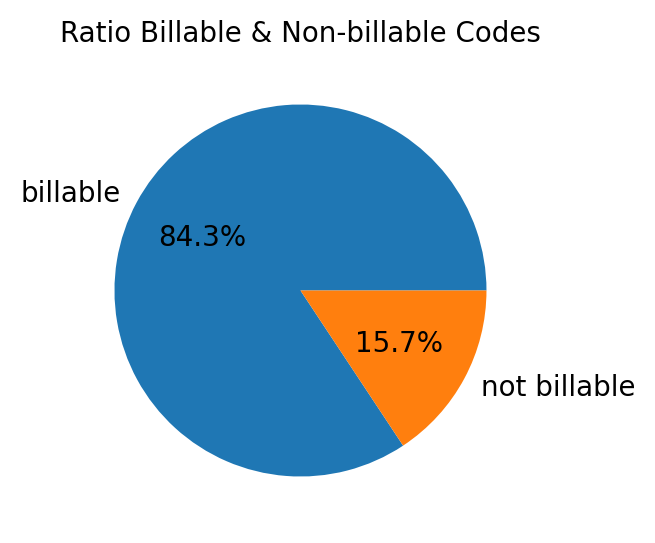

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3,4), dpi=200)
plt.pie(icd10_hcc_pdf['icd_code_billable'].value_counts(), 
        labels = ["billable", "not billable"], 
        autopct = "%1.1f%%"
       )
plt.title("Ratio Billable & Non-billable Codes", size=10)
plt.show()

As we can see, some of the best matching codes are not billable. For such indications we can find codes that are relevant as well as billable

In [0]:
icd10_oncology_mapping = {"C81-C96": "Malignant neoplasms of lymphoid, hematopoietic and related tissue",
                          "C76-C80": "Malignant neoplasms of ill-defined, other secondary and unspecified sites",
                          "D00-D09": "In situ neoplasms",
                          "C51-C58": "Malignant neoplasms of female genital organs",
                          "C43-C44": "Melanoma and other malignant neoplasms of skin",
                          "C15-C26": "Malignant neoplasms of digestive organs",
                          "C73-C75": "Malignant neoplasms of thyroid and other endocrine glands",
                          "D60-D64": "Aplastic and other anemias and other bone marrow failure syndromes",
                          "E70-E88": "Metabolic disorders",
                          "G89-G99": "Other disorders of the nervous system",
                          "R50-R69": "General symptoms and signs",
                          "R10-R19": "Symptoms and signs involving the digestive system and abdomen",
                          "Z00-Z13": "Persons encountering health services for examinations"}


def map_to_parent(x):
    charcode = x[0].lower()
    numcodes = int(x[1])
    
    for k, v in icd10_oncology_mapping.items():
        
        lower, upper = k.split('-')
        
        if charcode >= lower[0].lower() and numcodes >= int(lower[1]):
            
            if charcode < upper[0].lower():
                return v
            elif charcode == upper[0].lower() and numcodes <= int(upper[1]):
                return v

In [0]:
icd10_hcc_pdf["onc_code_desc"] = icd10_hcc_pdf["icd10_code"].apply(map_to_parent).fillna("-")

In [0]:
best_paid_icd_matches = []
indication_with_no_billable_icd = []

for i_, row in icd10_hcc_pdf.iterrows():
    if '1' not in row['billable']:
        indication_with_no_billable_icd.append([row['final_chunk'], 
                                      row['resolutions'][0], 
                                      row['all_codes'][0],
                                      row['billable'][0],
                                      row['hcc_score'][0],
                                      row['onc_code_desc'], 
                                      "-" ])
    else:
        n_zero_ind = list(row['billable']).index('1')
        best_paid_icd_matches.append([row['final_chunk'], 
                                      row['resolutions'][n_zero_ind], 
                                      row['all_codes'][n_zero_ind],
                                      row['billable'][n_zero_ind],
                                      row['hcc_score'][n_zero_ind],
                                      row['onc_code_desc'],
                                      n_zero_ind])

best_icd_mapped_pdf = pd.DataFrame(best_paid_icd_matches, columns=['ner_chunk', 'code_desc', 'code' , 'billable', 
                                             'corresponding_hcc_score', 'onc_code_desc', 'nearest_billable_code_pos'])
best_icd_mapped_pdf['corresponding_hcc_score'] = pd.to_numeric(best_icd_mapped_pdf['corresponding_hcc_score'], errors='coerce')

best_icd_mapped_pdf.head()

Out[32]:

,ner_chunk,code_desc,code,billable,corresponding_hcc_score,onc_code_desc,nearest_billable_code_pos
0,Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
1,Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
2,Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
3,cough,cough [Cough],R05,1,0.0,-,0
4,chest pain,chest pain [Pain in throat and chest],R074,1,0.0,-,0


**All chunks have been mapped to payable ICD codes**

In [0]:
print(best_icd_mapped_pdf.billable.value_counts())

1 1497
Name: billable, dtype: int64

#### Write `best_icd_mapped_df` to Delta
Now we can write the reimbursement-ready data with billable codes into a gold delta layer, which can be accessed for reporting and BI

In [0]:
best_icd_mapped_df = spark.createDataFrame(best_icd_mapped_pdf)
best_icd_mapped_df.write.format('delta').mode('overwrite').save(f'{delta_path}/gold/best-icd-mapped')

In [0]:
display(best_icd_mapped_df.limit(10))

ner_chunk,code_desc,code,billable,corresponding_hcc_score,onc_code_desc,nearest_billable_code_pos
Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
cough,cough [Cough],R05,1,0.0,-,0
chest pain,chest pain [Pain in throat and chest],R074,1,0.0,-,0
cough,cough [Cough],R05,1,0.0,-,0
chest pain,chest pain [Pain in throat and chest],R074,1,0.0,-,0
cancer,"cancer [Malignant (primary) neoplasm, unspecified]",C801,1,12.0,"Malignant neoplasms of lymphoid, hematopoietic and related tissue",0
numbness,numbness of skin [Paresthesia of skin],R202,1,0.0,-,0
tingling of her left arm,tingling sensation [Paresthesia of skin],R202,1,0.0,-,0


## 2. Get Drug codes from the notes

We will create a new pipeline to get drug codes. As NER model, we are using `ner_posology_large` and setting NerConverterInternal's WhiteList `['DRUG']` in order to get only drug entities.

In [0]:
## to get drugs
drugs_ner_ing = medical.NerModel.pretrained("ner_posology_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")\
    .setIncludeConfidence(False)

drugs_ner_converter_ing = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["DRUG"])
      
pipeline_rxnorm_ingredient = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_ing,
        drugs_ner_converter_ing])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_ner_model = pipeline_rxnorm_ingredient.fit(data_ner)

ner_posology_large download started this may take some time.
[ | ][ / ][OK!]

### Visualize Drug Entities

Now we will visualize a sample text with `NerVisualizer`.

`NerVisualizer` works with LightPipeline, so we will create a `rxnorm_lp` with our `rxnorm_model`.

In [0]:
rxnorm_ner_lp = nlp.LightPipeline(rxnorm_ner_model)

ann_text = rxnorm_ner_lp.fullAnnotate(sample_text.text)[0]
print(ann_text.keys())

dict_keys(['document', 'ner_chunk', 'token', 'ner_drug', 'embeddings', 'sentence'])

In [0]:
visualiser = viz.NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin DRUG 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone DRUG 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox DRUG 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were performed, which reve

Now we will take rxnorm ner_chunks into a list for using in resolver pipeline

In [0]:
rxnorm_code_res_df = rxnorm_ner_lp.transform(df) 

In [0]:
rxnorm_code_res_pdf = rxnorm_code_res_df.select("path", F.explode(F.arrays_zip('ner_chunk.result', 
                                                                      'ner_chunk.metadata')).alias("cols"))\
                         .select("path", F.expr("cols['result']").alias("ner_chunk"), 
                                         F.expr("cols['metadata']['entity']").alias("entity")).toPandas()

rxnorm_ner_chunks = list(rxnorm_code_res_pdf.ner_chunk)

We will create our resolver pipeline and get rxnorm codes of these ner_chunks.

In [0]:
sbert_embedder = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("rxnorm_code")\
  .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = nlp.PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            rxnorm_resolver
            ])

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [0]:
rxnorm_resolver_lp = nlp.LightPipeline(rxnorm_pipelineModel)

In [0]:
rxnorm_code_res = rxnorm_resolver_lp.fullAnnotate(rxnorm_ner_chunks)

We are selecting the columns which we need and convert to Pandas DataFrame. The values in `all_codes` and `resolitions` columns are seperated by ":::" and we are converting these columns to lists.

In [0]:
tuples = []

for i in range(len(rxnorm_code_res)):
    for x,y in zip(rxnorm_code_res[i]["ner_chunks"], rxnorm_code_res[i]["rxnorm_code"]):
        tuples.append((rxnorm_code_res_pdf.path.iloc[i],x.result, y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"]))

rxnorm_res_cleaned_pdf = pd.DataFrame(tuples, columns=["path", "drug_chunk", "rxnorm_code", "confidence", "all_codes", "resolutions"])


codes = []
resolutions = []

for code, resolution in zip(rxnorm_res_cleaned_pdf['all_codes'], rxnorm_res_cleaned_pdf['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_res_cleaned_pdf['all_codes'] = codes  
rxnorm_res_cleaned_pdf['resolutions'] = resolutions
rxnorm_res_cleaned_pdf['drugs'] = rxnorm_res_cleaned_pdf['resolutions'].apply(lambda x : x[0])

In [0]:
display(rxnorm_res_cleaned_pdf.head(5))

path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5621,"List(202421, 374998, 2898, 1855075, 218274, 152085, 1598, 128793, 2540, 1435932, 1167357, 214904, 225235, 20136, 78903, 376853, 370743, 154)","List(Coumadin, coumarin Oral Tablet, coumarin, coumaran, Medcodin, Mycifradin, dicumarol, Vicodin, cilastatin, Reumacetin, Cervidil Drug Implant Product, A-Cillin, Celontin, camylofine, capreomycin, capreomycin Injectable Solution, acenocoumarol Oral Tablet, acenocoumarol)",Coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone,703,0.4689,"List(703, 1663223, 1151983, 1151982, 203114, 1151981, 377132, 722, 370575, 620, 1944369, 151347, 1000082, 1000084, 370972, 18600, 203526, 17767, 2184119, 375754, 720)","List(amiodarone, amiodarone Injection, amiodarone Pill, amiodarone Oral Product, amiodarone hydrochloride, amiodarone Injectable Product, amiodarone Injectable Solution, amoxapine, amoxapine Oral Tablet, amantadine, amantadine Extended Release Oral Capsule, Amsidine, alcaftadine, alcaftadine Ophthalmic Solution, azatadine Oral Tablet, azatadine, Aramine, amlodipine, amlodipine Oral Suspension, amodiaquine Oral Tablet, amodiaquine)",amiodarone
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5621,"List(202421, 374998, 2898, 1855075, 218274, 152085, 1598, 128793, 2540, 1435932, 1167357, 214904, 225235, 20136, 78903, 376853, 370743, 154)","List(Coumadin, coumarin Oral Tablet, coumarin, coumaran, Medcodin, Mycifradin, dicumarol, Vicodin, cilastatin, Reumacetin, Cervidil Drug Implant Product, A-Cillin, Celontin, camylofine, capreomycin, capreomycin Injectable Solution, acenocoumarol Oral Tablet, acenocoumarol)",Coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Lovenox,225036,0.1188,"List(225036, 2472782, 2472778, 224937, 540404, 1999683, 218173, 833136, 686430, 2103170, 1441297, 277489, 217961, 991208)","List(Lovenox, relugolix Oral Tablet, relugolix, Sanorex, Lunesta, Lutathera, Magnalox, Savella, Lialda, Lorbrena, Agaricus campestris var. campestris whole extract, Lunelle, Laniroif, Naturetin)",Lovenox
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,353612,0.1239,"List(353612, 1718999, 12574, 215984, 1731354, 3041, 371250, 194000, 1373205, 1736853, 2555, 40048, 378363, 3639, 1790094, 215703, 378110, 239, 1806907)","List(Chemocycline, gemcitabine Injection, gemcitabine, Chemet, cytarabine Injection, cytarabine, capecitabine Oral Tablet, capecitabine, Apis cerana worker secretion preparation, cisplatin Injection, cisplatin, carboplatin, carboplatin Injectable Solution, doxorubicin, doxorubicin Injection, Blephamide, aclarubicin Injectable Solution, aclarubicin, decitabine Injection)",Chemocycline


#### Write `rxnorm_res_cleaned_df `to Delta

In [0]:
rxnorm_res_cleaned_df = spark.createDataFrame(rxnorm_res_cleaned_pdf)
rxnorm_res_cleaned_df.write.format('delta').mode('overwrite').save(f'{delta_path}/gold/rxnorm-res-cleaned')

In [0]:
display(rxnorm_res_cleaned_df.limit(5))

path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5621,"List(202421, 374998, 2898, 1855075, 218274, 152085, 1598, 128793, 2540, 1435932, 1167357, 214904, 225235, 20136, 78903, 376853, 370743, 154)","List(Coumadin, coumarin Oral Tablet, coumarin, coumaran, Medcodin, Mycifradin, dicumarol, Vicodin, cilastatin, Reumacetin, Cervidil Drug Implant Product, A-Cillin, Celontin, camylofine, capreomycin, capreomycin Injectable Solution, acenocoumarol Oral Tablet, acenocoumarol)",Coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone,703,0.4689,"List(703, 1663223, 1151983, 1151982, 203114, 1151981, 377132, 722, 370575, 620, 1944369, 151347, 1000082, 1000084, 370972, 18600, 203526, 17767, 2184119, 375754, 720)","List(amiodarone, amiodarone Injection, amiodarone Pill, amiodarone Oral Product, amiodarone hydrochloride, amiodarone Injectable Product, amiodarone Injectable Solution, amoxapine, amoxapine Oral Tablet, amantadine, amantadine Extended Release Oral Capsule, Amsidine, alcaftadine, alcaftadine Ophthalmic Solution, azatadine Oral Tablet, azatadine, Aramine, amlodipine, amlodipine Oral Suspension, amodiaquine Oral Tablet, amodiaquine)",amiodarone
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5621,"List(202421, 374998, 2898, 1855075, 218274, 152085, 1598, 128793, 2540, 1435932, 1167357, 214904, 225235, 20136, 78903, 376853, 370743, 154)","List(Coumadin, coumarin Oral Tablet, coumarin, coumaran, Medcodin, Mycifradin, dicumarol, Vicodin, cilastatin, Reumacetin, Cervidil Drug Implant Product, A-Cillin, Celontin, camylofine, capreomycin, capreomycin Injectable Solution, acenocoumarol Oral Tablet, acenocoumarol)",Coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Lovenox,225036,0.1188,"List(225036, 2472782, 2472778, 224937, 540404, 1999683, 218173, 833136, 686430, 2103170, 1441297, 277489, 217961, 991208)","List(Lovenox, relugolix Oral Tablet, relugolix, Sanorex, Lunesta, Lutathera, Magnalox, Savella, Lialda, Lorbrena, Agaricus campestris var. campestris whole extract, Lunelle, Laniroif, Naturetin)",Lovenox
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,353612,0.1239,"List(353612, 1718999, 12574, 215984, 1731354, 3041, 371250, 194000, 1373205, 1736853, 2555, 40048, 378363, 3639, 1790094, 215703, 378110, 239, 1806907)","List(Chemocycline, gemcitabine Injection, gemcitabine, Chemet, cytarabine Injection, cytarabine, capecitabine Oral Tablet, capecitabine, Apis cerana worker secretion preparation, cisplatin Injection, cisplatin, carboplatin, carboplatin Injectable Solution, doxorubicin, doxorubicin Injection, Blephamide, aclarubicin Injectable Solution, aclarubicin, decitabine Injection)",Chemocycline


Checking all posology entities `DRUG`, `FREQUENCY`, `DURATION`, `STRENGTH`, `FORM`, `DOSAGE` and `ROUTE` and their RXNORM Code by using `ner_posology_greedy` model. <br/>
We will take our greedy chunks into rxnorm resolver to see what will change

In [0]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

## to get drugs
drugs_ner_ing = medical.NerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")

drugs_ner_converter_ing = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk_drug")\
    .setWhiteList(["DRUG"])

greedy_ner_converter_ing = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk_greedy")

drugs_c2doc = nlp.Chunk2Doc().setInputCols("ner_chunk_drug").setOutputCol("ner_chunk_doc") 

sbert_embedder_ing = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")

rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models")\
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")
    

pipeline_rxnorm_ingredient = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_ing,
        drugs_ner_converter_ing, 
        greedy_ner_converter_ing,
        drugs_c2doc, 
        sbert_embedder_ing,
        rxnorm_resolver])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_model = pipeline_rxnorm_ingredient.fit(data_ner)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_posology_greedy download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[ | ][OK!]

In [0]:
rxnorm_greedy_lp = nlp.LightPipeline(rxnorm_model)

In [0]:
ann_text = rxnorm_greedy_lp.fullAnnotate(sample_text.text)[0]
print(ann_text.keys())

dict_keys(['ner_chunk_drug', 'document', 'ner_chunk_greedy', 'sentence_embeddings', 'token', 'rxnorm_code', 'ner_drug', 'embeddings', 'ner_chunk_doc', 'sentence'])

Visualize Greedy Algorithm Entities without WhiteList

In [0]:
visualiser = viz.NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(ann_text, label_col='ner_chunk_greedy',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg DRUG daily FREQUENCY . Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o DRUG . daily FREQUENCY . REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were per

In [0]:
rxnorm_code_res = rxnorm_model.transform(df) 

In [0]:
rxnorm_res = rxnorm_code_res.select("path", F.explode(F.arrays_zip( rxnorm_code_res.ner_chunk_drug.result, rxnorm_code_res.rxnorm_code.result, rxnorm_code_res.rxnorm_code.metadata)).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("drug_chunk"),
                                            F.expr("cols['1']").alias("rxnorm_code"),
                                            F.expr("cols['2']['confidence']").alias("confidence"),
                                            F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                            F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()


codes = []
resolutions = []

for code, resolution in zip(rxnorm_res['all_codes'], rxnorm_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_res['all_codes'] = codes  
rxnorm_res['resolutions'] = resolutions
rxnorm_res['drugs'] = rxnorm_res['resolutions'].apply(lambda x : x[0])

In [0]:
rxnorm_res.head(5)

Out[54]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin 1 mg,855289,0.5182,"[855289, 432469, 438737, 447086, 421570, 208469, 104885, 141932, 246018, 330877, 205485, 205489,...","[warfarin sodium 1 MG [Coumadin], coumarin 1 MG Oral Tablet, coumarin 1 MG, propinox 1 MG, propi...",warfarin sodium 1 MG [Coumadin]
1,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone 100 mg p.o,835956,0.1922,"[835956, 835955, 428768, 440437, 316837, 200220, 243321, 316417, 315363, 197363, 849389, 861027,...","[amiodarone hydrochloride 100 MG Oral Tablet, amiodarone hydrochloride 100 MG, ibopamine 100 MG ...",amiodarone hydrochloride 100 MG Oral Tablet
2,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5621,"[202421, 374998, 2898, 1855075, 218274, 152085, 1598, 128793, 2540, 1435932, 1167357, 214904, 22...","[Coumadin, coumarin Oral Tablet, coumarin, coumaran, Medcodin, Mycifradin, dicumarol, Vicodin, c...",Coumadin
3,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,353612,0.1239,"[353612, 1718999, 12574, 215984, 1731354, 3041, 371250, 194000, 1373205, 1736853, 2555, 40048, 3...","[Chemocycline, gemcitabine Injection, gemcitabine, Chemet, cytarabine Injection, cytarabine, cap...",Chemocycline
4,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cisplatin 75 mg/centimeter,748749,0.0847,"[748749, 1424917, 1424918, 687066, 2049119, 2049118, 210591, 262221, 827181, 328246, 199945, 105...","[clindamycin 75 MG [Cleocin], dabrafenib 75 MG, dabrafenib 75 MG Oral Capsule, porfimer sodium 7...",clindamycin 75 MG [Cleocin]


In [0]:
rxnorm_code_greedy_res_pdf = rxnorm_code_res.select("path", F.explode(F.arrays_zip('ner_chunk_drug.result', 
                                                               'ner_chunk_drug.metadata')).alias("cols"))\
                         .select("path", F.expr("cols['result']").alias("ner_chunk"), 
                                         F.expr("cols['metadata']['entity']").alias("entity")).toPandas()

#### Write `rxnorm_code_greedy_res_df` to Delta

In [0]:
dbutils.fs.rm(f"{delta_path}/silver/rxnorm-code-greedy-res", recurse=True)

Out[56]: True

In [0]:
rxnorm_code_greedy_res_df=spark.createDataFrame(rxnorm_code_greedy_res_pdf)
rxnorm_code_greedy_res_df.write.format('delta').mode("overwrite").save(f"{delta_path}/silver/rxnorm-code-greedy-res")

In [0]:
display(rxnorm_code_greedy_res_df.limit(10))

path,ner_chunk,entity
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin 1 mg,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone 100 mg p.o,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cisplatin 75 mg/centimeter,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,109 mg IV piggyback,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Alimta 500 mg/ centimeter squared equaling 730 mg IV piggyback,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,IV fluid and IV,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,heparin,DRUG


## 3. Get Timeline Using RE Models

We will create a relation extration model to identify temporal relationships among clinical events by using pretrained **RelationExtractionModel** `re_temporal_events_clinical`.

In [0]:
pos_tagger = nlp.PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

events_ner_tagger = medical.NerModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("ner_tags")\
    .setIncludeConfidence(False)

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = nlp.DependencyParserModel.pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

clinical_re_Model = medical.RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = nlp.Pipeline(stages=[
  documentAssembler,
  sentenceDetector,
  tokenizer, 
  word_embeddings, 
  pos_tagger, 
  events_ner_tagger,
  ner_chunker,
  dependency_parser,
  clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][ / ][OK!]
ner_events_clinical download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ][ / ][ — ][OK!]

In [0]:
temporal_re_df = model.transform(df)

Now we write the results in our delta silver layer

In [0]:
temporal_re_df_silver = temporal_re_df.select("path", F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols"))\
                                  .select("path",
                                          F.expr("cols['result']").alias("relation"),
                                          F.expr("cols['metadata']['entity1']").alias('entity1'),
                                          F.expr("cols['metadata']['chunk1']").alias('chunk1'),
                                          F.expr("cols['metadata']['entity2']").alias('entity2'),
                                          F.expr("cols['metadata']['chunk2']").alias('chunk2'),
                                          F.expr("cols['metadata']['confidence']").alias('confidence')
                                         )

#### Write `temporal_re_df_silver` Delta

In [0]:
temporal_re_df_silver.write.format('delta').mode("overwrite").save(f"{delta_path}/silver/temporal-re")

## 4. Relations Between Body Parts and Procedures

We will create a relation extration model to identify relationships between body parts and problem entities by using pretrained **RelationExtractionModel** `re_bodypart_problem`.

In [0]:
pos_tagger = nlp.PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

ner_tagger = medical.NerModel() \
    .pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_tags")\
    .setIncludeConfidence(False)

ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_tags"]) \
    .setOutputCol("ner_chunks_re")\
    .setWhiteList(['Internal_organ_or_component', 'Problem', 'Procedure'])

dependency_parser = nlp.DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["sentence", "pos_tags", "token"]) \
    .setOutputCol("dependencies")

re_model = medical.RelationExtractionModel()\
    .pretrained('re_bodypart_problem', 'en', "clinical/models") \
    .setPredictionThreshold(0.5)\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks_re", "dependencies"]) \
    .setOutputCol("relations")

bodypart_re_pipeline = nlp.Pipeline(stages=[documentAssembler, 
                            sentenceDetector, 
                            tokenizer, 
                            pos_tagger, 
                            word_embeddings, 
                            ner_tagger, 
                            ner_converter,
                            dependency_parser, 
                            re_model])


empty_data = spark.createDataFrame([['']]).toDF("text")
bodypart_re_model = bodypart_re_pipeline.fit(empty_data)

pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
[ | ][ / ][ — ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][OK!]
re_bodypart_problem download started this may take some time.
Approximate size to download 9.2 MB
[ | ][ / ][ — ][OK!]

In [0]:
bodypart_re_df = bodypart_re_model.transform(df)

In [0]:
bodypart_re_df = bodypart_re_df.select("path", F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols"))\
                                .select("path",
                                        F.expr("cols['result']").alias("relation"),
                                        F.expr("cols['metadata']['entity1']").alias('entity1'),
                                        F.expr("cols['metadata']['chunk1']").alias('chunk1'),
                                        F.expr("cols['metadata']['entity2']").alias('entity2'),
                                        F.expr("cols['metadata']['chunk2']").alias('chunk2'),
                                        F.expr("cols['metadata']['confidence']").alias('confidence')
                                        )

#### Write `bodypart_re_df` to Delta

In [0]:
bodypart_re_df.write.format('delta').mode("overwrite").save(f'{delta_path}/silver/bodypart-relationships')

In [0]:
display(bodypart_re_df.limit(10))

path,relation,entity1,chunk1,entity2,chunk2,confidence
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Procedure,decortication of the lung,Procedure,pleural biopsy,0.9999919
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Procedure,pericardectomy,Procedure,pericardectomy,0.9264386
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Procedure,chest tube placement,Procedure,thoracoscopy,0.99982053
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Procedure,chest tube placement,Procedure,fluid biopsies,0.5048493
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Procedure,thoracoscopy,Procedure,fluid biopsies,1.0
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Internal_organ_or_component,pectoral,Internal_organ_or_component,intramammary lymph nodes,0.5477111
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Internal_organ_or_component,pectoral,Internal_organ_or_component,L4,0.9999999
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Internal_organ_or_component,intramammary lymph nodes,Internal_organ_or_component,L4,0.9942292
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_1.txt,0,Procedure,Excision of large basal cell carcinoma,Procedure,dorsal conjunctival flap,0.9885477
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_1.txt,0,Procedure,Excision of large basal cell carcinoma,Procedure,dorsal conjunctival flap,0.9999963


## 5. Get Procedure codes from notes

We will create a new pipeline to get procedure codes. As NER model, we are using `jsl_ner_wip_greedy_clinical` and setting NerConverterInternal's WhiteList `['Procedure']` in order to get only drug entities.

In [0]:
proc_ner = medical.NerModel.pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_proc")\
    .setIncludeConfidence(False)

proc_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_proc"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['Procedure'])


bert_pipeline_cpt = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        proc_ner,
        proc_ner_converter])

empty_data = spark.createDataFrame([['']]).toDF("text")
cpt_model = bert_pipeline_cpt.fit(empty_data)

jsl_ner_wip_greedy_clinical download started this may take some time.
[ | ][OK!]

In [0]:
cpt_code_res = cpt_model.transform(df) 

Now we will take the ner_chunks into a list to use in resolver pipeline

In [0]:
cpt_ner_df = cpt_code_res.select("path", F.explode(F.arrays_zip('ner_chunk.result', 
                                                                'ner_chunk.metadata')).alias("cols"))\
                         .select("path", F.expr("cols['result']").alias("ner_chunk"), 
                                         F.expr("cols['metadata']['entity']").alias("entity")).toPandas()

cpt_ner_chunks = list(cpt_ner_df.ner_chunk)

In [0]:
sbert_embedder = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

cpt_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("cpt_code")\
  .setDistanceFunction("EUCLIDEAN")

cpt_pipelineModel = nlp.PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            cpt_resolver
            ])

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
sbiobertresolve_cpt_augmented download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][OK!]

In [0]:
cpt_lp = nlp.LightPipeline(cpt_pipelineModel)

In [0]:
cpt_code_res = cpt_lp.fullAnnotate(cpt_ner_chunks)

In [0]:
tuples = []

for i in range(len(cpt_code_res)):
    for x,y in zip(cpt_code_res[i]["ner_chunks"], cpt_code_res[i]["cpt_code"]):
        tuples.append((cpt_ner_df.path.iloc[i],x.result, cpt_ner_df.entity.iloc[i], y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"]))

cpt_df = pd.DataFrame(tuples, columns=["path", "chunks", "entity", "cpt_code", "confidence", "all_codes", "resolutions"])



codes = []
resolutions = []

for code, resolution in zip(cpt_df['all_codes'], cpt_df['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
cpt_df['all_codes'] = codes  
cpt_df['resolutions'] = resolutions
cpt_df['cpt'] = cpt_df['resolutions'].apply(lambda x : x[0])

In [0]:
cpt_df.head()

Out[75]:

,path,chunks,entity,cpt_code,confidence,all_codes,resolutions,cpt
0,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,decortication of the lung,Procedure,32225,0.3863,"[32225, 32651, 39545, 36823, 32215, 33025, 1005980, 31320, 1005815, 32110, 32652, 32220, 32310, ...","[Partial decortication of lung, Partial decortication of lung, Imbrication of diaphragm, Decannu...",Partial decortication of lung
1,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,pleural biopsy,Procedure,32098,0.9951,"[32098, 32095, 32609, 32604, 32400, 32491, 1007169, 37200, 75970, 32096, 32607, 32097, 32608, 10...","[Pleural biopsy, Open pleural biopsy, Thoracoscopy; with biopsy(ies) of pleura, Pericardial biop...",Pleural biopsy
2,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,thoracentesis,Procedure,32555,0.4992,"[32555, 32421, 32036, 1005962, 35820, 32668, 32657, 32660, 32667, 32671, 1020900, 32653, 32654, ...","[Thoracentesis, Thoracentesis, Thoracostomy, Thoracostomy, Thoracostomy, Thoracoscopy, Thoracosc...",Thoracentesis
3,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Port-A-Cath placement,Procedure,36593,0.0751,"[36593, 75970, 49325, 20555, 62318, 75989, 62160, 64446, 55875, 49419, 41019, 19296, 61770, 1929...","[Catheter procedure (procedure), Catheter procedure (procedure), Catheter procedure (procedure),...",Catheter procedure (procedure)
4,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,pericardectomy,Procedure,33031,0.2498,"[33031, 33025, 33030, 32660, 33020, 64746, 49250, 27566, 27350, 27424, 27524]","[Pericardectomy, Pericardectomy, Pericardectomy, Pericardectomy, Pericardotomy, Phrenicectomy, O...",Pericardectomy


### Write `cpt_df` to Delta

In [0]:
cpt_df=spark.createDataFrame(cpt_df)
cpt_df.write.format('delta').mode('overwrite').save(f"{delta_path}/silver/cpt")

## 6. Get Assertion Status of Cancer Entities

We will create a new pipeline to get assertion status of cancer entities procedure codes. As NER model, we are using `jsl_ner_wip_greedy_clinical`.

In [0]:
# Cancer
bionlp_ner = medical.NerModel.pretrained("ner_bionlp", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("bionlp_ner")\
    .setIncludeConfidence(False)

bionlp_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "bionlp_ner"]) \
    .setOutputCol("bionlp_ner_chunk")\
    .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = medical.NerModel.pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")\
    .setIncludeConfidence(False)

jsl_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Oncological", "Symptom"])

chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols('bionlp_ner_chunk', "jsl_ner_chunk")\
    .setOutputCol('final_ner_chunk')

cancer_assertion = medical.AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "final_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")


assertion_pipeline = nlp.Pipeline(
    stages = base_stages+[
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        cancer_assertion
    ])
empty_data = spark.createDataFrame([['']]).toDF("text")
assertion_model = assertion_pipeline.fit(empty_data)

ner_bionlp download started this may take some time.
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
[ | ][OK!]
assertion_dl download started this may take some time.
[ | ][ / ][ — ][ \ ][OK!]

In [0]:
assertion_res = assertion_model.transform(df)

In [0]:
assertion_df = (assertion_res.selectExpr('*', 'final_ner_chunk.result as final_ner_chunk_result', 'final_ner_chunk.metadata as final_ner_chunk_metadata', 'assertion.result as assertion_result')
                .select("path", F.explode(F.arrays_zip('final_ner_chunk_result', 'final_ner_chunk_metadata', 'assertion_result')).alias("cols"))
                .select("path", F.expr("cols['final_ner_chunk_result']").alias("chunk"),
                                F.expr("cols['final_ner_chunk_metadata']['entity']").alias("entity"),
                                F.expr("cols['assertion_result']").alias("assertion"))
               )

In [0]:
assertion_df.head(10)

Out[80]: [Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='Mesothelioma', entity='Oncological', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='Mesothelioma', entity='Oncological', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='Mesothelioma', entity='Oncological', assertion='associated_with_someone_else'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='nonproductive cough', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='chest pain', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='cough', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='chest pain', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='cancer', entity='Cancer', assertion='associated_with_someone_else'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='occasional numbness', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='tingling of her left arm', entity='Symptom', assertion='present')]

#### Write `assertion_df` to Delta

In [0]:
assertion_df.write.format('delta').mode('overwrite').save(f'{delta_path}/silver/assertion')

## License
Copyright / License info of the notebook. Copyright [2021] the Notebook Authors.  The source in this notebook is provided subject to the [Apache 2.0 License](https://spdx.org/licenses/Apache-2.0.html).  All included or referenced third party libraries are subject to the licenses set forth below.

|Library Name|Library License|Library License URL|Library Source URL| 
| :-: | :-:| :-: | :-:|
|Pandas |BSD 3-Clause License| https://github.com/pandas-dev/pandas/blob/master/LICENSE | https://github.com/pandas-dev/pandas|
|Numpy |BSD 3-Clause License| https://github.com/numpy/numpy/blob/main/LICENSE.txt | https://github.com/numpy/numpy|
|Apache Spark |Apache License 2.0| https://github.com/apache/spark/blob/master/LICENSE | https://github.com/apache/spark/tree/master/python/pyspark|
|Spark NLP |Apache-2.0 License| https://github.com/JohnSnowLabs/spark-nlp/blob/master/LICENSE | https://github.com/JohnSnowLabs/spark-nlp|
|MatPlotLib | | https://github.com/matplotlib/matplotlib/blob/master/LICENSE/LICENSE | https://github.com/matplotlib/matplotlib|
|Seaborn | | https://github.com/seaborn/seaborn/blob/master/licences/HUSL_LICENSE | https://github.com/seaborn/seaborn/|
|Pillow (PIL) | HPND License| https://github.com/python-pillow/Pillow/blob/master/LICENSE | https://github.com/python-pillow/Pillow/|
|Spark NLP for Healthcare|[Proprietary license - John Snow Labs Inc.](https://www.johnsnowlabs.com/spark-nlp-health/) |NA|NA|
|Spark OCR |[Proprietary license - John Snow Labs Inc.](https://nlp.johnsnowlabs.com/docs/en/ocr) |NA|NA|

|Author|
|-|
|Databricks Inc.|
|John Snow Labs Inc.|

## Disclaimers
Databricks Inc. (“Databricks”) does not dispense medical, diagnosis, or treatment advice. This Solution Accelerator (“tool”) is for informational purposes only and may not be used as a substitute for professional medical advice, treatment, or diagnosis. This tool may not be used within Databricks to process Protected Health Information (“PHI”) as defined in the Health Insurance Portability and Accountability Act of 1996, unless you have executed with Databricks a contract that allows for processing PHI, an accompanying Business Associate Agreement (BAA), and are running this notebook within a HIPAA Account.  Please note that if you run this notebook within Azure Databricks, your contract with Microsoft applies.